In [1]:
# 導入必要的庫
import os
import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter, defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
import seaborn as sns
%matplotlib inline


c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 定義資料目錄
data_dir = 'data/'

# 定義類別和對應的標籤
categories = {'non': 0, 'swallow': 1}

# 列出所有音頻文件及其標籤
audio_files = []
labels = []

for category, label in categories.items():
    category_dir = os.path.join(data_dir, category)
    for file in os.listdir(category_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(category_dir, file)
            audio_files.append(file_path)
            labels.append(label)

print(f"總音頻文件數量: {len(audio_files)}")
print(f"標籤分佈: {Counter(labels)} (非吞嚥: {categories['non']}, 吞嚥: {categories['swallow']})")


總音頻文件數量: 137
標籤分佈: Counter({0: 70, 1: 67}) (非吞嚥: 0, 吞嚥: 1)


In [3]:
def load_audio(file_path, sr=16000):
    """
    讀取音頻文件並返回音頻信號和採樣率。

    參數:
    - file_path: 音頻文件的路徑
    - sr: 採樣率，默認為22050

    返回:
    - y: 音頻信號
    - sr: 採樣率
    """
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr


In [4]:
def reduce_noise_signal(y, sr):
    """
    使用noisereduce庫進行噪音抑制。

    假設音頻的前0.5秒為背景噪音。

    參數:
    - y: 音頻信號
    - sr: 採樣率

    返回:
    - y_reduced: 去噪後的音頻信號
    """
    noise_sample = y[:int(0.5 * sr)]  # 假設前0.5秒為背景噪音
    y_reduced = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
    return y_reduced


In [5]:
def split_audio(y, sr, segment_length, hop_length):
    """
    將音頻信號分割成固定長度的片段。如果最後一個片段不足指定長度，則進行填充。

    參數:
    - y: 音頻信號
    - sr: 採樣率
    - segment_length: 每個片段的長度（秒）
    - hop_length: 窗口跳步長度（秒）

    返回:
    - segments: 分割後的音頻片段列表
    """
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    num_segments = 0

    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segments.append(y[start:end])
        num_segments += 1

    # 處理最後一個不足長度的片段
    remaining_samples = len(y) - (num_segments * hop_samples)
    if remaining_samples > 0 and remaining_samples < segment_samples:
        last_segment = y[-segment_samples:]
        padding = segment_samples - len(last_segment)
        last_segment_padded = np.pad(last_segment, (0, padding), mode='constant')
        segments.append(last_segment_padded)

    return segments

In [6]:
def extract_features(y, sr, n_mels=128, n_fft=2048, hop_length=512, fixed_length=130):
    """
    從音頻信號中提取梅爾頻譜圖特徵，並確保每個特徵具有固定的時間步數。

    參數:
    - y: 音頻信號
    - sr: 採樣率
    - n_mels: 梅爾頻帶數量
    - n_fft: 快速傅立葉變換窗口大小
    - hop_length: 窗口跳步長度
    - fixed_length: 固定的時間步數（帧數）

    返回:
    - mel_spec_db: 轉換為分貝的梅爾頻譜圖，形狀為 (n_mels, fixed_length)
    """
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # 固定長度
    mel_spec_db = librosa.util.fix_length(mel_spec_db, size=fixed_length, axis=1)

    return mel_spec_db


In [7]:
features = []
labels_processed = []

# 計數每個類別的片段數量
segment_counts = defaultdict(int)

# 定義固定的時間步數（根據您的設置調整）
fixed_length = 130

# 迭代處理每個音頻文件
for file_path, label in zip(audio_files, labels):
    # 讀取音頻
    y, sr = load_audio(file_path)

    # 去噪（可選）
    y = reduce_noise_signal(y, sr)

    # 分割音頻
    segments = split_audio(y, sr, segment_length=1.0, hop_length=0.5)

    # 如果分割後沒有片段，跳過該文件
    if not segments:
        continue

    # 對每個片段提取特徵
    for segment in segments:
        mel_spec = extract_features(segment, sr, fixed_length=fixed_length)
        mel_spec = mel_spec[..., np.newaxis]  # 添加channel維度
        features.append(mel_spec)
        labels_processed.append(label)
        segment_counts[label] += 1

print(f"總片段數量: {len(features)}")
print("每個類別的片段數量:", dict(segment_counts))

總片段數量: 203
每個類別的片段數量: {0: 135, 1: 68}


In [8]:
# 將特徵和標籤轉換為NumPy數組
X = np.array(features)
y = np.array(labels_processed)

print(f"特徵形狀: {X.shape}")
print(f"標籤形狀: {y.shape}")

# 將數值標準化到0-1之間
X = X / np.max(X)

print(f"標準化後的特徵形狀: {X.shape}")

特徵形狀: (203, 128, 130, 1)
標籤形狀: (203,)
標準化後的特徵形狀: (203, 128, 130, 1)


In [9]:
from sklearn.model_selection import train_test_split

# 分割訓練集和測試集
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print(f"訓練集大小: {X_train.shape}")
    print(f"測試集大小: {X_test.shape}")
except ValueError as e:
    print("分層抽樣失敗，嘗試不使用 stratify")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"訓練集大小: {X_train.shape}")
    print(f"測試集大小: {X_test.shape}")


訓練集大小: (162, 128, 130, 1)
測試集大小: (41, 128, 130, 1)


In [10]:
# 將標籤轉為類別
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"訓練集標籤形狀: {y_train.shape}")
print(f"測試集標籤形狀: {y_test.shape}")


訓練集標籤形狀: (162, 2)
測試集標籤形狀: (41, 2)


In [11]:
# 計算類別權重
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("類別權重:", class_weights_dict)


類別權重: {0: 0.75, 1: 1.5}


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

def build_deep_cnn(input_shape):
    """
    建立更深的CNN模型架構。

    參數:
    - input_shape: 輸入數據的形狀，例如 (128, 130, 1)

    返回:
    - model: 建立好的Keras模型
    """
    model = Sequential()
    
    # 第一個卷積塊
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # 第二個卷積塊
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # 第三個卷積塊
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # 第四個卷積塊
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # 展平層
    model.add(Flatten())
    
    # 全連接層
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    # 輸出層
    model.add(Dense(2, activation='softmax'))
    
    return model

# 獲取輸入形狀
input_shape = X_train.shape[1:]  # 假設形狀為 (128, 130, 1)
print("輸入形狀:", input_shape)

# 建立更深的CNN模型
model = build_deep_cnn(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


輸入形狀: (128, 130, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 130, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 130, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 65, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 65, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 65, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None,

Epoch 1/30
11/11 [==============================] - 3s 245ms/step - loss: 16.1538 - accuracy: 0.5617 - val_loss: 2.6167 - val_accuracy: 0.8537
Epoch 2/30
11/11 [==============================] - 3s 231ms/step - loss: 2.3152 - accuracy: 0.7654 - val_loss: 54.4023 - val_accuracy: 0.6585
Epoch 3/30
11/11 [==============================] - 3s 231ms/step - loss: 0.8052 - accuracy: 0.7963 - val_loss: 116.9875 - val_accuracy: 0.6585
Epoch 4/30
11/11 [==============================] - 3s 229ms/step - loss: 1.6139 - accuracy: 0.7840 - val_loss: 28.5078 - val_accuracy: 0.6585
Epoch 5/30
11/11 [==============================] - 3s 231ms/step - loss: 1.8683 - accuracy: 0.7593 - val_loss: 1.4451 - val_accuracy: 0.9024
Epoch 6/30
11/11 [==============================] - 3s 228ms/step - loss: 0.6850 - accuracy: 0.7531 - val_loss: 1.3991 - val_accuracy: 0.9024
Epoch 7/30
11/11 [==============================] - 2s 227ms/step - loss: 0.6957 - accuracy: 0.7901 - val_loss: 0.8928 - val_accuracy: 0.9024
E

C:\Users\bymin\AppData\Local\Temp\ipykernel_25760\3974939055.py:26: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_25760\3974939055.py:26: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_25760\3974939055.py:26: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bymin\AppData\Local\Temp\ipykernel_25760\3974939055.py:26: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bymin\anaconda3\envs\swallow\lib\site-package

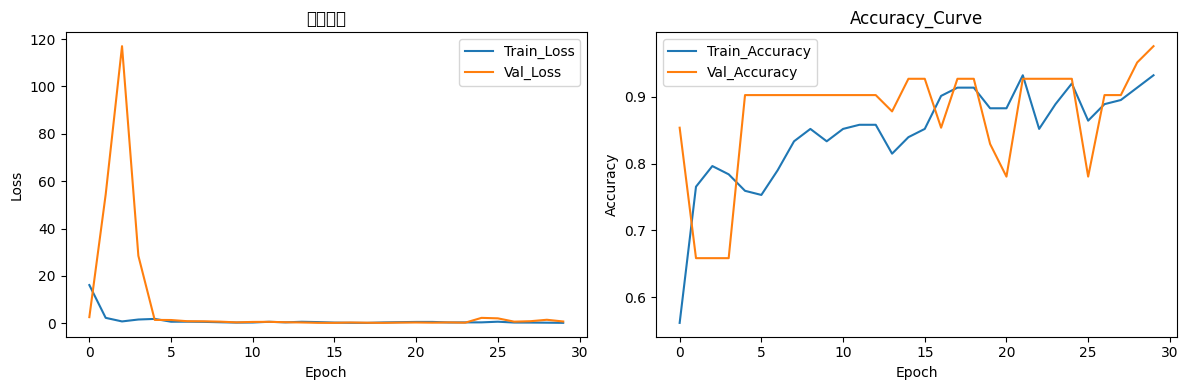

In [13]:
# 訓練模型，並使用類別權重
history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)
# 繪製訓練過程
plt.figure(figsize=(12, 4))

# 繪製損失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train_Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.title('損失曲線')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 繪製準確率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train_Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.title('Accuracy_Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [14]:
# 評估模型在測試集上的表現
loss, accuracy = model.evaluate(X_test, y_test)
print(f"測試集損失: {loss:.4f}")
print(f"測試集準確率: {accuracy * 100:.2f}%")


2/2 [==============================] - 0s 35ms/step - loss: 0.7811 - accuracy: 0.9756
測試集損失: 0.7811
測試集準確率: 97.56%


2/2 [==============================] - 0s 38ms/step
ConfusionMatrix:
[[26  1]
 [ 0 14]]

分類報告:
              precision    recall  f1-score   support

 Non Swallow       1.00      0.96      0.98        27
     Swallow       0.93      1.00      0.97        14

    accuracy                           0.98        41
   macro avg       0.97      0.98      0.97        41
weighted avg       0.98      0.98      0.98        41



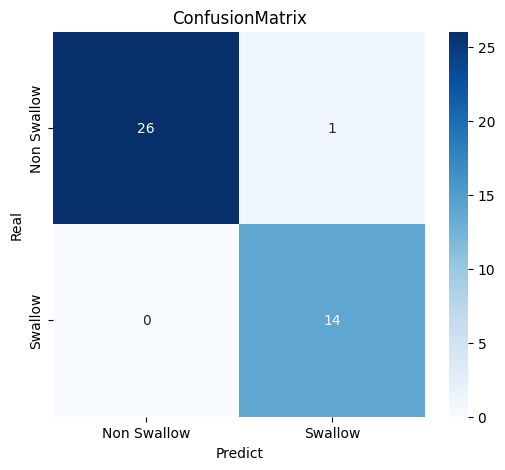

In [15]:
# 預測測試集
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred_classes)
print("ConfusionMatrix:")
print(cm)

# 分類報告
print("\n分類報告:")
print(classification_report(y_true, y_pred_classes, target_names=['Non Swallow', 'Swallow']))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Swallow', 'Swallow'],
            yticklabels=['Non Swallow', 'Swallow'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('ConfusionMatrix')
plt.show()



In [16]:
def sliding_window_predict(y, sr, model, window_length=1.0, hop_length=0.5, threshold=0.5, fixed_length=130):
    """
    使用滑動窗口方法對整個音頻進行預測，並計數吞嚥聲音的數量。

    參數:
    - y: 音頻信號
    - sr: 採樣率
    - model: 已訓練的CNN模型
    - window_length: 窗口長度（秒）
    - hop_length: 窗口跳步長度（秒）
    - threshold: 判斷為吞嚥聲音的概率閾值
    - fixed_length: 固定的時間步數（帧數）

    返回:
    - count: 吞嚥聲音的數量
    """
    window_samples = int(window_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    predictions = []

    for start in range(0, len(y) - window_samples + 1, hop_samples):
        end = start + window_samples
        window = y[start:end]
        mel_spec = extract_features(window, sr, fixed_length=fixed_length)
        mel_spec = mel_spec[..., np.newaxis]  # 添加channel維度
        mel_spec = mel_spec / np.max(mel_spec)  # 標準化
        mel_spec = mel_spec.reshape(1, mel_spec.shape[0], mel_spec.shape[1], mel_spec.shape[2])
        pred = model.predict(mel_spec, verbose=0)
        predictions.append(pred[0][1])  # 吞嚥聲音的概率

    # 根據閾值判斷吞嚥事件
    swallowing_events = []
    for i, prob in enumerate(predictions):
        if prob > threshold:
            swallowing_events.append(i)

    # 去除重疊的事件
    min_distance = int(window_length / hop_length * 1)  # 最小間隔，根據實際情況調整
    final_events = []
    last_event = -min_distance
    for event in swallowing_events:
        if event - last_event > min_distance:
            final_events.append(event)
            last_event = event

    return len(final_events)


In [17]:
# 定義新的音頻文件路徑
new_audio_path = '音檔\測試RSST 2.wav'  # 替換為您的音頻文件路徑

# 檢查文件是否存在
if not os.path.exists(new_audio_path):
    print(f"音頻文件 {new_audio_path} 不存在。請確認路徑正確。")
else:
    # 讀取新的音頻文件
    y_new, sr_new = load_audio(new_audio_path)

    # 可選：去噪
    y_new = reduce_noise_signal(y_new, sr_new)

    # 使用滑動窗口方法進行預測和計數
    count = sliding_window_predict(y_new, sr_new, model, window_length=1.0, hop_length=0.5, threshold=0.4, fixed_length=130)
    print(f"吞嚥聲音數量: {count}")



C:\Users\bymin\AppData\Local\Temp\ipykernel_25760\4081547629.py:27: RuntimeWarning: divide by zero encountered in divide
  mel_spec = mel_spec / np.max(mel_spec)  # 標準化
C:\Users\bymin\AppData\Local\Temp\ipykernel_25760\4081547629.py:27: RuntimeWarning: invalid value encountered in divide
  mel_spec = mel_spec / np.max(mel_spec)  # 標準化


吞嚥聲音數量: 1
